## Right Parameters for Convergence of 
# Hexagonal Boron Nitride ($hBN$) SIESTA simulation


In [1]:
import numpy as np
import sisl
import sisl.viz
import plotly.express as px
import matplotlib.pyplot as plt
import os
from Pseudopotential_file_generator import *
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

In [2]:
output_path="./hBN_Convergence_Study/"
siesta_path = "/home/melanie/Desktop/siesta-4.1.5/EXECUTABLE/siesta" 
#"/opt/anaconda3/envs/siesta/bin/siesta" #...write siesta path here

# Create the geometry
graphene = sisl.geom.graphene()
hBN = sisl.Geometry( graphene.axyz(), 
                     [sisl.Atom('B'), sisl.Atom('N')],
                     graphene.sc.scale(1.0205))
# Plot it to see that it is what we wanted
hBN.plot(axes="xy")

FigureWidget({
    'data': [{'line': {'color': '#cccccc', 'width': 3},
              'mode': 'lines',
        …

## (a) Basis Size

In [3]:
# Define all the basis sizes that we want to try.
basis_sizes = ['SZ', 'SZP', 'DZ', 'TZ', 'DZP', 'DZDP', 'TZP', 'TZDP', 'TZTP']

Nkx=13
Nky=13
Nkz=1

In [4]:
for basis_size in basis_sizes:
    print(f"RUNNING SIMULATION FOR BASIS: {basis_size} K GRID: Nkx={Nkx} Nky={Nky} Nkz={Nkz}")

    out_dir = output_path+f"hBN_Basis_{basis_size}_Nkx={Nkx}_Nky={Nky}_Nkz={Nkz}/"

    os.makedirs(out_dir, exist_ok=True)

    generate_B_psf(out_dir+"/B.psf")
    generate_N_psf(out_dir+"/N.psf")

    hBN.write(out_dir+ "/geom.fdf")

    # Inside this directory, open a RUN.fdf file, which will be our main input file. 
    with open(out_dir+ '/RUN.fdf', 'w') as f:
        # We include the fdf file that contains the geometry, with the %include statement
        # Note the \n, which means "new line" in text files.
        f.write("%include geom.fdf \n")
        # We now include the basis size input.
        f.write(f"PAO.BasisSize {basis_size}\n")
        #f.write("TS.HS.Save true\n") # save Hamiltonian for band structure analysis
        #f.write("SaveRho true\n") # save density of electrons in geometry
        k_grid=f"%block kgrid.MonkhorstPack\n{Nkx} 0 0  0\n 0 {Nky} 0  0\n   0 0 {Nkz}  0\n%endblock kgrid.MonkhorstPack\n"
        f.write(k_grid)
        #f.write("DM.MixingWeight  0.100\nDM.NumberPulay  3\n")
    
    # We have the directory set up, we can run the siesta calculation
    os.system(f"cd {out_dir}; {siesta_path} RUN.fdf > RUN.out")

RUNNING SIMULATION FOR BASIS: SZ K GRID: Nkx=13 Nky=13 Nkz=1
RUNNING SIMULATION FOR BASIS: SZP K GRID: Nkx=13 Nky=13 Nkz=1
RUNNING SIMULATION FOR BASIS: DZ K GRID: Nkx=13 Nky=13 Nkz=1
RUNNING SIMULATION FOR BASIS: TZ K GRID: Nkx=13 Nky=13 Nkz=1
RUNNING SIMULATION FOR BASIS: DZP K GRID: Nkx=13 Nky=13 Nkz=1
RUNNING SIMULATION FOR BASIS: DZDP K GRID: Nkx=13 Nky=13 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=13 Nky=13 Nkz=1
RUNNING SIMULATION FOR BASIS: TZDP K GRID: Nkx=13 Nky=13 Nkz=1
RUNNING SIMULATION FOR BASIS: TZTP K GRID: Nkx=13 Nky=13 Nkz=1


Parse the outputs of SIESTA.

In [5]:
# Initialize an empty list to store the energies.
Es = []
times = []

# Loop over Nks
for basis_size in basis_sizes:
    # Define the directory where this basis size calculation has run.
    out_dir = output_path+f"hBN_Basis_{basis_size}_Nkx={Nkx}_Nky={Nky}_Nkz={Nkz}/"
    
    # Initialize a parser for the output file (RUN.out) with sisl. From
    # this, we will be able to read many things that are written there.
    # See docs: https://zerothi.github.io/sisl/api/io/generated/sisl.io.siesta.outSileSiesta.html#sisl.io.siesta.outSileSiesta
    out_file = sisl.get_sile(out_dir + "/RUN.out")
    # We read all the energies
    energies = out_file.read_energy()
    
    # In particular, we care about the total energy, which we get and store in the list
    Etot = energies['total']
    Es.append(Etot)
    
    with open(out_dir + "/RUN.out", "r") as f:
        for line in f:
            if "Elapsed wall time (sec)" in line:
                times.append(float(line.split("time (sec) = ")[-1]))

We plot the results.

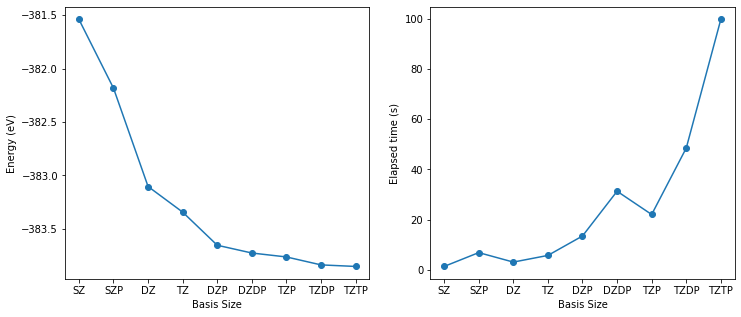

In [6]:
fig = plt.figure( figsize=(12,5))
ax = fig.subplots(1,2)
l=list(range(len(basis_sizes)))
ax[0].plot(l, Es, 'o-')
ax[1].plot(l, times, 'o-')
ax[0].set_xlabel("Basis Size")
ax[0].set_ylabel("Energy (eV)")
ax[1].set_xlabel("Basis Size")
ax[1].set_ylabel("Elapsed time (s)")
ax[0].set_xticks(l, labels=basis_sizes)
ax[1].set_xticks(l, labels=basis_sizes)
plt.savefig(output_path+"/hBN_basis_convergence.png", dpi=100)
plt.show()

We see that the value at TZP is already in the converged range of energies. Since the required time for better bases increases greatly afterwards, we will consider this one for the coming computations.

## (b) k-grid Size

In [3]:
# Define the grid of parameters to try
basis_size = 'TZP'
max_Nk = 27

Nkxs = list(range(1,10))+list(range(13, max_Nk, 3))
Nkys = list(range(1,10))+list(range(13, max_Nk, 3))
Nkzs = [1]*len(Nkxs)+[3]*len(Nkxs)
Nkxs*=2
Nkys*=2

Run the grid of SIESTA simulations.

In [8]:
for Nkx, Nky, Nkz in zip(Nkxs, Nkys, Nkzs):
    print(f"RUNNING SIMULATION FOR BASIS: {basis_size} K GRID: Nkx={Nkx} Nky={Nky} Nkz={Nkz}")

    out_dir = output_path+f"hBN_Basis_{basis_size}_Nkx={Nkx}_Nky={Nky}_Nkz={Nkz}/"

    os.makedirs(out_dir, exist_ok=True)

    generate_N_psf(out_dir+"/N.psf")
    generate_B_psf(out_dir+"/B.psf")

    hBN.write(out_dir+ "/geom.fdf")

    # Inside this directory, open a RUN.fdf file, which will be our main input file. 
    with open(out_dir+ '/RUN.fdf', 'w') as f:
        # We include the fdf file that contains the geometry, with the %include statement
        # Note the \n, which means "new line" in text files.
        f.write("%include geom.fdf \n")
        # We now include the basis size input.
        f.write(f"PAO.BasisSize {basis_size}\n")
        f.write("TS.HS.Save true\n") # save Hamiltonian for band structure analysis
        f.write("SaveRho true\n") # save density of electrons in geometry
        k_grid=f"%block kgrid.MonkhorstPack\n{Nkx} 0 0  0\n 0 {Nky} 0  0\n   0 0 {Nkz}  0\n%endblock kgrid.MonkhorstPack\n"
        f.write(k_grid)
        #f.write("DM.MixingWeight  0.100\nDM.NumberPulay  3\n")
    
    # We have the directory set up, we can run the siesta calculation
    os.system(f"cd {out_dir}; {siesta_path} RUN.fdf > RUN.out")

RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=1 Nky=1 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=2 Nky=2 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=3 Nky=3 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=4 Nky=4 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=5 Nky=5 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=6 Nky=6 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=7 Nky=7 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=8 Nky=8 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=9 Nky=9 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=13 Nky=13 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=16 Nky=16 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=19 Nky=19 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=22 Nky=22 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=25 Nky=25 Nkz=1
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=1 Nky=1 Nkz=3
RUNNING SIMULATION FOR BASIS: TZP K GRID: Nkx=2 Nky=2 Nkz=3
RUNNING SIMULATION FOR BASIS: 

Parse the outputs of SIESTA.

In [9]:
# Initialize an empty list to store the energies.
Es = []
times = []

# Loop over Nks
for Nkx, Nky, Nkz in zip(Nkxs, Nkys, Nkzs):
    # Define the directory where this basis size calculation has run.
    out_dir = output_path+f"hBN_Basis_{basis_size}_Nkx={Nkx}_Nky={Nky}_Nkz={Nkz}/"
    
    # Initialize a parser for the output file (RUN.out) with sisl. From
    # this, we will be able to read many things that are written there.
    # See docs: https://zerothi.github.io/sisl/api/io/generated/sisl.io.siesta.outSileSiesta.html#sisl.io.siesta.outSileSiesta
    out_file = sisl.get_sile(out_dir + "/RUN.out")
    # We read all the energies
    energies = out_file.read_energy()
    
    # In particular, we care about the total energy, which we get and store in the list
    Etot = energies['total']
    Es.append(Etot)
    
    with open(out_dir + "/RUN.out", "r") as f:
        for line in f:
            if "Elapsed wall time (sec)" in line:
                times.append(float(line.split("time (sec) = ")[-1]))

We plot the results.

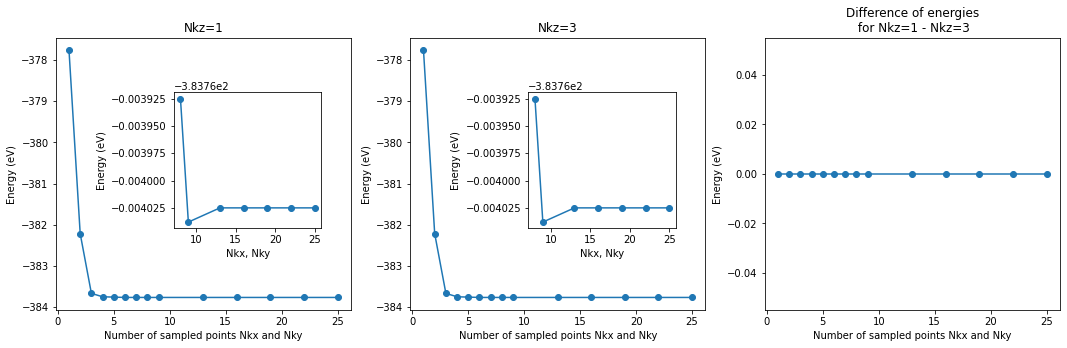

In [10]:
Es=np.array(Es)
mini=7
titles=["Nkz=1", "Nkz=3", "Difference of energies\n for Nkz=1 - Nkz=3"]
fig = plt.figure( figsize=(18,5))
ax = fig.subplots(1,3)
ax[0].plot(Nkxs[:len(Nkxs)//2], Es[:len(Nkxs)//2], 'o-', label="Nkz=1")
ax[1].plot(Nkxs[len(Nkxs)//2:], Es[len(Nkxs)//2:], 'o-', label="Nkz=3")
ax[2].plot(Nkxs[len(Nkxs)//2:], Es[:len(Nkxs)//2]-Es[len(Nkxs)//2:], 'o-')
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax[0], [0.4,0.3,0.5,0.5])
ax2.set_axes_locator(ip)
ax2.set_ylabel("Energy (eV)")
ax2.set_xlabel("Nkx, Nky")
ax2.plot(Nkxs[mini:len(Nkxs)//2], Es[mini:len(Nkxs)//2], 'o-')
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax[1], [0.4,0.3,0.5,0.5])
ax2.set_axes_locator(ip)
ax2.plot(Nkxs[len(Nkxs)//2+mini:], Es[len(Nkxs)//2+mini:], 'o-')
ax2.set_ylabel("Energy (eV)")
ax2.set_xlabel("Nkx, Nky")
for j,a in enumerate(ax):
    a.set_title(titles[j])
    a.set_xlabel("Number of sampled points Nkx and Nky")
    a.set_ylabel("Energy (eV)")
    #a.legend()
plt.savefig(output_path+"/hBN_energy_k.png", dpi=100)
plt.show()

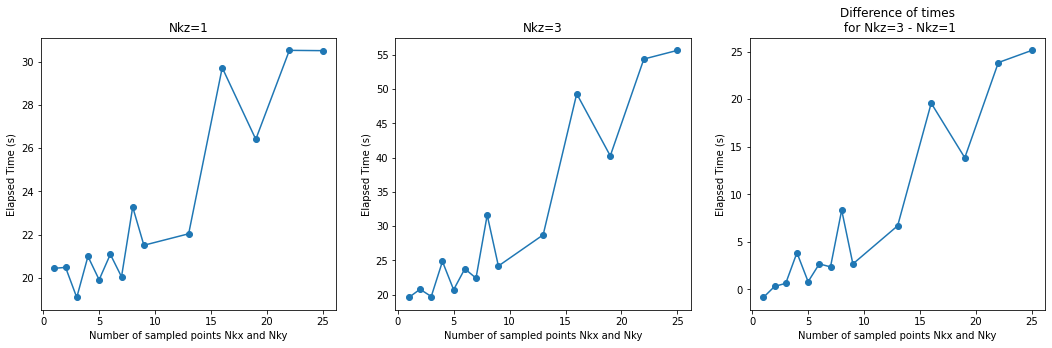

In [11]:
times=np.array(times)
mini=8
titles=["Nkz=1", "Nkz=3", "Difference of times\n for Nkz=3 - Nkz=1"]
fig = plt.figure( figsize=(18,5))
ax = fig.subplots(1,3)
ax[0].plot(Nkxs[:len(Nkxs)//2], times[:len(Nkxs)//2], 'o-', label="Nkz=1")
ax[1].plot(Nkxs[len(Nkxs)//2:], times[len(Nkxs)//2:], 'o-', label="Nkz=3")
ax[2].plot(Nkxs[len(Nkxs)//2:], -times[:len(Nkxs)//2]+times[len(Nkxs)//2:], 'o-')

for j,a in enumerate(ax):
    a.set_title(titles[j])
    a.set_xlabel("Number of sampled points Nkx and Nky")
    a.set_ylabel("Elapsed Time (s)")
    #a.legend()
plt.savefig(output_path+"/hBN_energy_t.png", dpi=100)
plt.show()

We see that it is enough for a converged energy to use a grid of $(Nk_x,Nk_y, Nk_z)=(13,13,1)$. More Nk_x, Nk_y do not affect the resulting energy significantly but the increase in computational time becomes more than double, while increasing $Nk_z>1$ appear inncessary, since the resulting energies turn out to be practically the same. This last was to be expected since hBN is a 2D material.

# Hexagonal Boron Nitride ($hBN$) Band Structure
We will use the Hamiltonian computed for $(Nk_x,Nk_y, Nk_z)=(13,13,1)$.

In [4]:
out_dir = output_path+f"hBN_Basis_{basis_size}_Nkx={13}_Nky={13}_Nkz={1}/"

H = sisl.get_sile(f"{out_dir}/RUN.fdf").read_hamiltonian()

# We need to define a path of k points
band_struct = sisl.BandStructure(H, points=[[0, 0, 0], [2/3, 1/3, 0], [1/2, 0, 0]],
    divisions=100, names=[r"\Gamma", "M", "K"]
)

In [5]:
# Then we can plot the bands
band_struct.plot()

FigureWidget({
    'data': [{'hoverinfo': 'name',
              'hovertemplate': '%{y:.2f} eV',
              …

In [31]:
# Get the fatbands plot
fatbands = band_struct.plot.fatbands()
# Split the contributions by the n and l quantum numbers
fatbands.split_groups(on="n+l+m", scale=15)

FigureWidget({
    'data': [{'fill': 'toself',
              'legendgroup': ' | n=2, l=0, m=0',
              …

In [34]:
# Get the fatbands plot
fatbands = band_struct.plot.fatbands()
# Split the contributions by the n and l quantum numbers
fatbands.split_groups(on="atom", scale=15)

FigureWidget({
    'data': [{'fill': 'toself',
              'legendgroup': ' | atom=0',
              'line':…

In [8]:
# Get the PDOS plot
pdos_plot = H.plot.pdos(
    kgrid=[40,40,1], nE=1000, Erange=[-10, 10],
    distribution={"method": "gaussian", "smearing": 0.1}
)
# Split the contributions by the n and l quantum numbers
pdos_plot.split_DOS(on="n+l", name="Atom $atoms")

FigureWidget({
    'data': [{'line': {'dash': 'solid', 'width': 1.0},
              'mode': 'lines',
         …

In [7]:
rho = sisl.get_sile(f"{out_dir}/RUN.fdf").read_grid("RHO")
rho.plot(axes="xy", plot_geom=True)

FigureWidget({
    'data': [{'type': 'heatmap',
              'uid': '0a430fe6-8db3-4bf8-8610-152120a1dfe3',
 …